In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import scipy.stats as stats

sys.path.append("..")
from util.plot import Background

%matplotlib inline

/home/vsip/soft/miniconda2/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [52]:
df = pd.read_pickle("../run/Taa/df-results-rec.pkl")
df = df[df.is_taa]
df = df.drop(columns=["model", "noise"]) 
df['tdur'] = df.tto - df.tfr

# Read seizure onset
df['onset'] = 0.
for subject, rec in df[['subject', 'rec']].drop_duplicates().values:
    t_onset = np.load(f"../data/Recordings/{subject}/rec_{rec:04d}.npz")['onset']
    df.loc[(df.subject == subject) & (df.rec == rec), 'onset'] = t_onset
    
# Make time relative to seizure onset
df.tfr = df.tfr - df.onset
df.tto = df.tto - df.onset

In [53]:
df['ntaa_on_elec'] = 0
for subject, rec, elec in df[['subject', 'rec', 'elec']].drop_duplicates().values:
    mask = ((df.subject == subject) & (df.rec == rec) & (df.elec == elec))
    dff = df[mask]
    df.loc[mask, 'ntaa_on_elec'] = len(dff)

In [54]:
dfg = df[df.is_ingroup]
dfn = df[~df.is_ingroup]


## Main figure

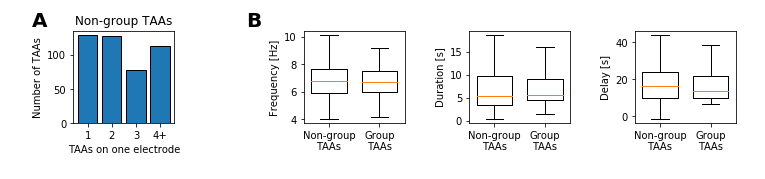

In [55]:
fig = plt.figure(figsize=(10, 2))

gs = GridSpec(1, 5, left=0.06, right=0.98, top=0.86, bottom=0.22, width_ratios=[1, 0.0, 1, 1, 1], wspace=0.8)

# Panel A
plt.subplot(gs[0])

counts = dfn.ntaa_on_elec.clip(upper=4).value_counts()

plt.bar(counts.index, counts.values, ec='k')
plt.xticks(np.r_[1:5], ["1", "2", "3", "4+"])
plt.title("Non-group TAAs")
plt.ylabel("Number of TAAs")
plt.xlabel("TAAs on one electrode")


# Panel B
features = ['freq', 'tdur', 'tfr']
feature_names = ["Frequency [Hz]", "Duration [s]", "Delay [s]"]

for i in range(len(features)):
    plt.subplot(gs[i+2])
    plt.boxplot([dfn[features[i]], dfg[features[i]]], widths=0.7, showfliers=False)
    plt.xticks([1, 2], ["Non-group\nTAAs", "Group\nTAAs"])
    plt.ylabel(feature_names[i])

bg = Background(visible=False)
bg.labels([0.002, 0.3], [0.86, 0.86], fontsize=20)

plt.savefig("figs/nongroup-taas.pdf")

In [56]:
# Statistics
for i in range(len(features)):
    res = stats.mannwhitneyu(dfg[features[i]], dfn[features[i]])
    print(f"{feature_names[i]:15s}: {res.statistic}  {res.pvalue:.4f}")
    
    
print(f"n grp    : {len(dfg)}")
print(f"n non-grp: {len(dfn)}")

Frequency [Hz] : 34639.5  0.2646
Duration [s]   : 33969.0  0.1634
Delay [s]      : 33732.5  0.1346
n grp    : 160
n non-grp: 448


In [57]:
(df.ntaa_on_elec == 1).mean(), (dfn.ntaa_on_elec == 1).mean(), 

(0.21217105263157895, 0.28794642857142855)